# Preparation

### Import, constants and functions

In [31]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [32]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [33]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [34]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [35]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [36]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

In [37]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [38]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    4310 samples
Test set:     1437 samples
Sample dims:  (4310, 54, 96, 3)


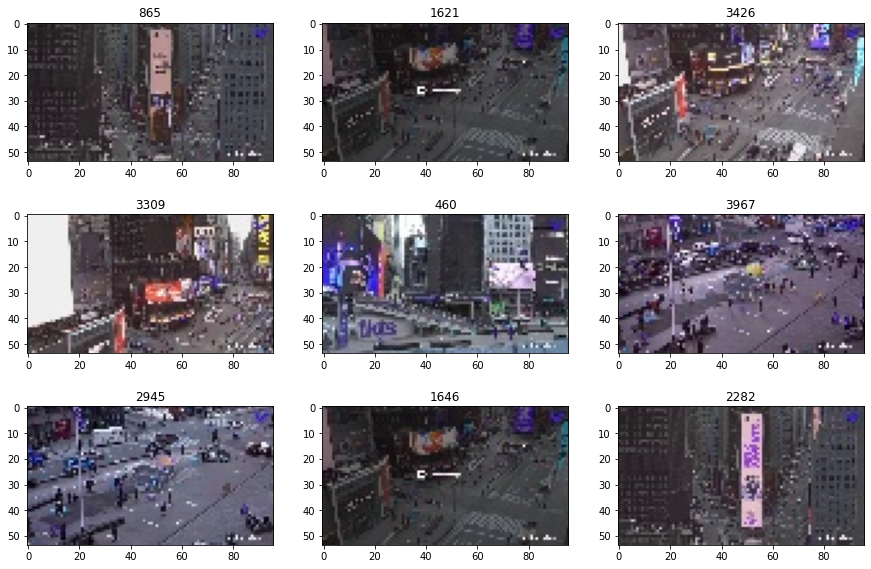

In [39]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [40]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Create model

In [41]:
latent_dim = 5000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(4, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([        
        layers.Dense(width*hight*3, activation='sigmoid'),
        layers.Reshape((hight, width, 3)),
        layers.Conv2DTranspose(3, kernel_size=(3, 3), activation="relu", padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [42]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [43]:
epochs = 10
batch_size = 16
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/10
270/270 [==============================] - 122s 448ms/step - loss: 0.0406 - accuracy: 0.4662 - val_loss: 0.0152 - val_accuracy: 0.5898
Epoch 2/10
270/270 [==============================] - 119s 442ms/step - loss: 0.0132 - accuracy: 0.6049 - val_loss: 0.0111 - val_accuracy: 0.6221
Epoch 3/10
270/270 [==============================] - 119s 442ms/step - loss: 0.0102 - accuracy: 0.6391 - val_loss: 0.0096 - val_accuracy: 0.6513
Epoch 4/10
270/270 [==============================] - 120s 444ms/step - loss: 0.0091 - accuracy: 0.6587 - val_loss: 0.0083 - val_accuracy: 0.6762
Epoch 5/10
270/270 [==============================] - 121s 449ms/step - loss: 0.0079 - accuracy: 0.6773 - val_loss: 0.0076 - val_accuracy: 0.6818
Epoch 6/10
270/270 [==============================] - 119s 441ms/step - loss: 0.0075 - accuracy: 0.6931 - val_loss: 0.0074 - val_accuracy: 0.6934
Epoch 7/10
270/270 [==============================] - 120s 445ms/step - loss: 0.0070 - accuracy: 0.7039 - val_loss: 0.0069 -

Train Acc      0.7345578074455261
Validation Acc 0.7470542788505554


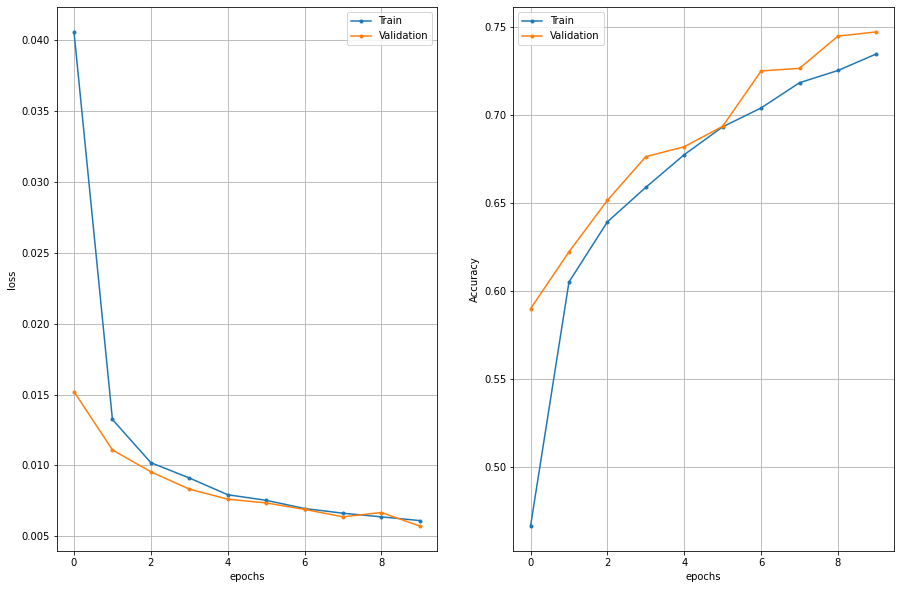

In [44]:
show_results(history)

In [45]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

In [46]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (1437, 5000)
Sample decoded:  (1437, 54, 96, 3)
comression:  3.1104


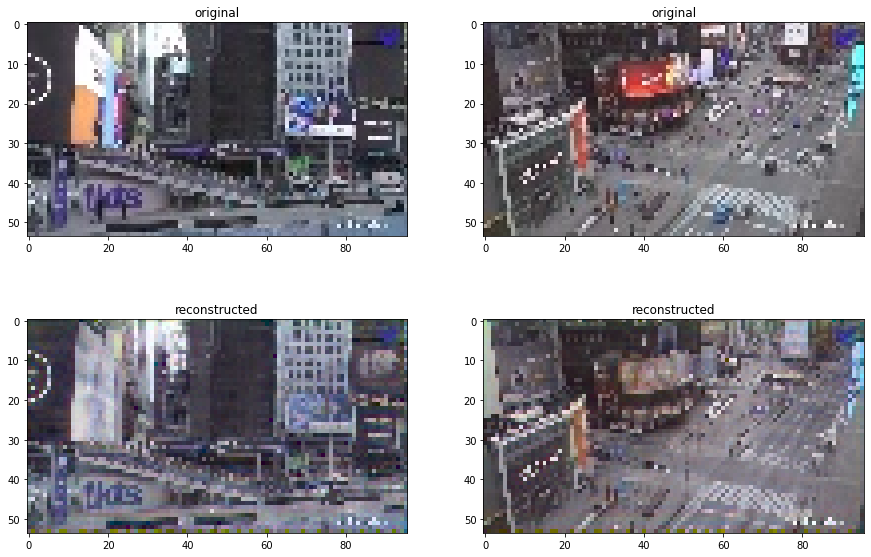

In [47]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)

In [48]:
autoencoder.summary()

Model: "autoencoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 5000)              25925112  
                                                                 
 sequential_7 (Sequential)   (None, 54, 96, 3)         77775636  
                                                                 
Total params: 103,700,748
Trainable params: 103,700,748
Non-trainable params: 0
_________________________________________________________________


In [49]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, None, None, 4)     112       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 4)    0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, None)              0         
                                                                 
 dense_6 (Dense)             (None, 5000)              25925000  
                                                                 
Total params: 25,925,112
Trainable params: 25,925,112
Non-trainable params: 0
_________________________________________________________________


In [50]:
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 15552)             77775552  
                                                                 
 reshape_3 (Reshape)         (None, 54, 96, 3)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 54, 96, 3)        84        
 ranspose)                                                       
                                                                 
Total params: 77,775,636
Trainable params: 77,775,636
Non-trainable params: 0
_________________________________________________________________
